In [1]:
using Pkg; Pkg.activate("."); #Pkg.add("Polynomials")
using Statistics
using PyPlot
using Glob
using DelimitedFiles
using MUST
using LaTeXStrings 
using Interpolations
using KernelDensity
using Polynomials

  Activating environment at `/cobra/ptmp/peitner/model_grid/MUST.jl/examples/solar_model/Project.toml`


Import dispatch routines and plotting tools

In [2]:
MUST.@import_dispatch "../../../dispatch2_clean/dispatch2" 
MUST.@import_dispatch "../../../dispatch2_clean/dispatch2" EOS 
MUST.@get_help visual
pl = pyimport("matplotlib.pylab");

In [3]:
get_teff(folder) = begin
    path = joinpath(folder, "teff.dat")
    if !ispath(path) @warn "$(path) does not exist."
        return nothing
    end
    data = readdlm(path)
end 

get_teff (generic function with 1 method)

There are a range of models, we compare the last snapshot of each of them with the solar model

In [4]:
solar_model = readdlm("solar_model.txt");

Next, we get a list of all the data folders that have been created for this grid

In [5]:
data_in = "data";

In [6]:
folders = glob("grid*/", MUST.@in_dispatch(data_in));

We first pick models with an effective temperature close to the solar value. 

In [7]:
teff_models = get_teff.(folders);

In [8]:
mean_residuals = zeros(length(teff_models))

for i in 1:length(teff_models)
    x, y = teff_models[i][:, 1], teff_models[i][:, 2]

    cutoff = Int(ceil(0.6*length(y)))

    mean_residuals[i] = mean(abs.(y .- 5777.0))
end

min_model = argmin(mean_residuals);

In [9]:
@info "Model closetst to solar effective temperature: $(folders[min_model])"

┌ Info: Model closetst to solar effective temperature: /cobra/ptmp/peitner/model_grid/dispatch2_clean/dispatch2/experiments/stellar_atmospheres/data/grid22_phase1/
└ @ Main /ptmp/peitner/model_grid/MUST.jl/examples/solar_model/analyze_solar_model.ipynb:1


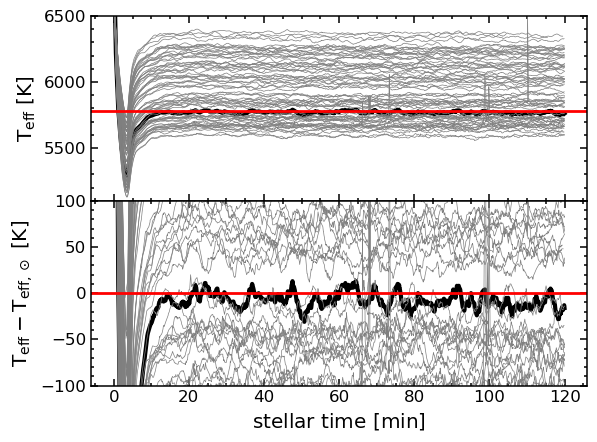

In [10]:
close("all")

f, ax  = plt.subplots(2,1, sharex=true)
basic_plot!.(ax)
plt.subplots_adjust(hspace=0.0)

ax[1].set_ylabel(@L_str("\\rm T_{eff} \\ [K]"), fontsize="x-large")
ax[2].set_ylabel(@L_str("\\rm T_{eff} - T_{eff,\\odot} \\ [K]"), fontsize="x-large")
ax[2].set_xlabel(@L_str("\\rm stellar \\ time\\ [min]"), fontsize="x-large")

for i in 1:length(teff_models)
    x, y = teff_models[i][:, 1], teff_models[i][:, 2]

    if i != min_model
        color="0.5"
        lw=.5
    else
        color="k"
        lw=3
    end

    ax[1].plot(x, y, color=color, lw=lw)
    ax[2].plot(x, y.-5777.0, color=color, lw=lw)
end

ax[1].axhline(5777.0, color="red", lw=2)
ax[2].axhline(0.0,    color="red", lw=2)
ax[2].set_ylim(-100,100)
ax[1].set_ylim(5100,6500)
;

gcf()

Compare the profile of the closest model to the profile of the sun

In [11]:
best_model = MUST.Boxes(folders[min_model]);

In [12]:
all_models = MUST.Boxes.(folders[1:3:end]);

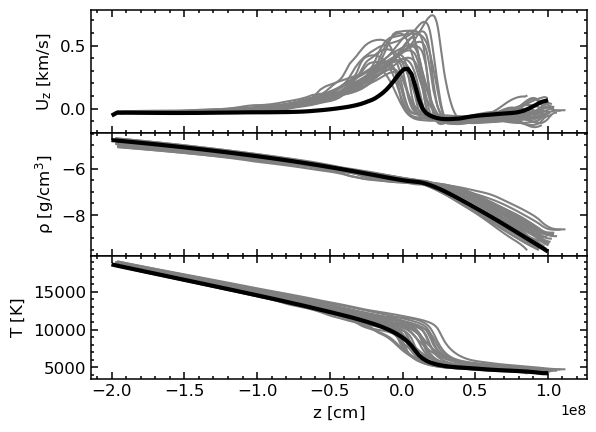

In [38]:
close("all")

f, ax  = plt.subplots(3,1, sharex=true)
basic_plot!.(ax)
plt.subplots_adjust(hspace=0.0)

# optical depth scale model
model = best_model[1]

# overlay other models
for i in 1:length(all_models)
    v  = MUST.plane_statistic(mean, all_models[i][2][end-1], :T) 
    d  = MUST.plane_statistic(mean, all_models[i][2][end-1], :d) 
    u  = MUST.plane_statistic(mean, all_models[i][2][end-1], :uz) .* 1e-5
    t  = all_models[i][2][end-1][:z][1,1,:]
    ax[1].plot(t, u, color="0.5")
    ax[2].plot(t, log10.(d), color="0.5")
    ax[3].plot(t, v, color="0.5")
end

# mean of the last 3 snapshots (15 min. time average)
sstart = length(model) - 1
send   = length(model) - 1

v  = MUST.plane_statistic(mean, model[end-1], :T) 
d  = MUST.plane_statistic(mean, model[end-1], :d) 
u  = MUST.plane_statistic(mean, model[end-1], :uz) .* 1e-5
t  = model[end-1][:z][1,1,:]

mask = sortperm(t)
t = t[mask]
v = v[mask]
d = d[mask]
u = u[mask]

ax[1].plot(t, u, label="closest model", color="k", lw=3)
ax[2].plot(t, log10.(d), label="closest model", color="k", lw=3)
ax[3].plot(t, v, label="closest model", color="k", lw=3)

ax[1].set_ylabel(@L_str("\\rm U_z\\ [km/s]"), fontsize="large")
ax[2].set_ylabel(@L_str("\\rm \\rho\\ [g/cm^3]"), fontsize="large")
ax[3].set_ylabel(@L_str("\\rm T\\ [K]"), fontsize="large");
ax[3].set_xlabel(@L_str("\\rm z\\ [cm]"), fontsize="large");

#ax[3].set_ylim(3000,8000)

gcf()

Distributions of profile

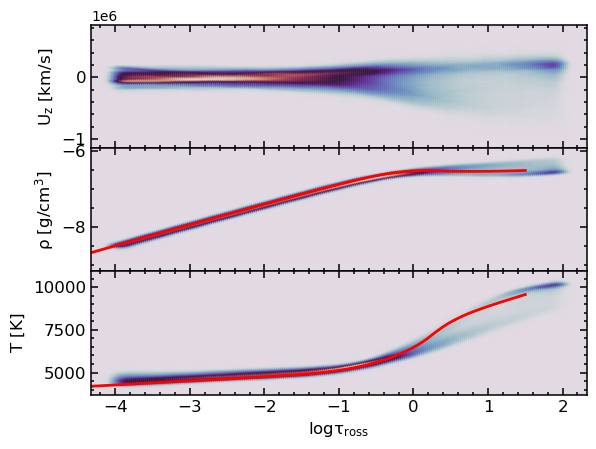

In [39]:
close("all")

f, ax  = plt.subplots(3,1, sharex=true)
basic_plot!.(ax)
plt.subplots_adjust(hspace=0.0)

# geometrical scale model
model = best_model[1][end-1]

u = reshape(model[:uz], :)
t = reshape(model[:τ_ross], :)  
mask = (t.<2.0) .& (t.>-4)

k = kde((t[mask],u[mask]))
xv = getindex.(Iterators.product(k.x, k.y), 1)  
yv = getindex.(Iterators.product(k.x, k.y), 2)
ax[1].scatter(xv, yv, c=k.density, cmap="twilight", s=0.1);
ax[1].set_xlim(minimum(k.x), maximum(k.x))
ax[1].set_ylim(minimum(k.y), maximum(k.y))

d = reshape(model[:d], :)
k = kde((t[mask],log.(10,d)[mask]))
xv = getindex.(Iterators.product(k.x, k.y), 1)  
yv = getindex.(Iterators.product(k.x, k.y), 2)
ax[2].scatter(xv, yv, c=k.density, cmap="twilight", s=0.1);
ax[2].set_xlim(minimum(k.x), maximum(k.x))
ax[2].set_ylim(minimum(k.y), maximum(k.y))


T = reshape(model[:T], :)
k = kde((t[mask],T[mask]))
xv = getindex.(Iterators.product(k.x, k.y), 1)  
yv = getindex.(Iterators.product(k.x, k.y), 2)
im= ax[3].scatter(xv, yv, c=k.density, cmap="twilight", s=0.1);
ax[3].set_xlim(minimum(k.x), maximum(k.x))
ax[3].set_ylim(minimum(k.y), maximum(k.y));

ax[1].set_ylabel(@L_str("\\rm U_z\\ [km/s]"), fontsize="large")
ax[2].set_ylabel(@L_str("\\rm \\rho\\ [g/cm^3]"), fontsize="large")
ax[3].set_ylabel(@L_str("\\rm T\\ [K]"), fontsize="large");
ax[3].set_xlabel(@L_str("\\rm \\log\\tau_{ross}"), fontsize="large");

gcf()

Comparison of distributions at specific optical depth

In [15]:
model           = best_model[1][end-1]                             # geometrical height data
optical_surface = MUST.height_where(; τ_ross=-1.0)                 # function that interpolates height where lgtau=0
b_1             = MUST.reduce_by_column(optical_surface, model);   # Reduce data cube to plane by interp. in height according to optical surface 

In [16]:
optical_surface = MUST.height_where(; τ_ross=-2.0)                  
b_2             = MUST.reduce_by_column(optical_surface, model);
optical_surface = MUST.height_where(; τ_ross=-3.0)                  
b_3             = MUST.reduce_by_column(optical_surface, model);

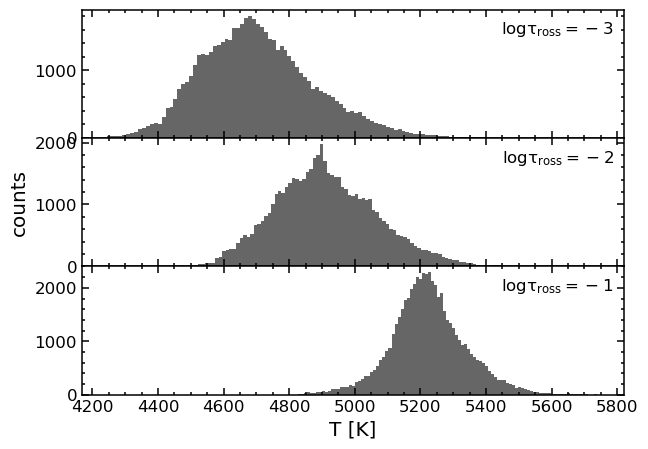

In [17]:
close("all")

f, ax  = plt.subplots(3,1, sharex=true, figsize=(7,5))
basic_plot!.(ax)
plt.subplots_adjust(hspace=0.0)

ax[3].hist(reshape(b_1[:T], :), bins=100, color="0.4");
ax[2].hist(reshape(b_2[:T], :), bins=100, color="0.4");
ax[1].hist(reshape(b_3[:T], :), bins=100, color="0.4");

ax[1].text(0.98, 0.92, @L_str("\\rm \\log \\tau_{ross} = -3"), fontsize="large",
           ha="right", va="top", transform=ax[1].transAxes)
ax[2].text(0.98, 0.92, @L_str("\\rm \\log \\tau_{ross} = -2"), fontsize="large",
            ha="right", va="top", transform=ax[2].transAxes)
ax[3].text(0.98, 0.92, @L_str("\\rm \\log \\tau_{ross} = -1"), fontsize="large",
            ha="right", va="top", transform=ax[3].transAxes)

ax[3].set_xlabel("T [K]", fontsize="x-large")
ax[2].set_ylabel("counts", fontsize="x-large");

gcf()

The initial conditions translate to final conditions in the following way

In [26]:
# Name of the namelist of the current folder
nml_name = MUST.@in_dispatch "$(splitpath(folders[min_model])[end])"

# Init namelist
nml = MUST.StellarNamelist(nml_name*".nml");

In [28]:
t_ini = Float64[]
t_eff = Float64[]
d_ini = Float64[]
t_s   = Float64[]
for i in 1:3:length(teff_models)
    x, y = teff_models[i][:, 1], teff_models[i][:, 2]

    append!(t_eff, [mean(y[50:end])])

    # Name of the namelist of the current folder
    nml_name = MUST.@in_dispatch "$(splitpath(folders[i])[end])"

    # Init namelist
    nml = MUST.StellarNamelist(nml_name*".nml")

    append!(t_ini, [nml.stellar_params["tt_k"]])
    append!(d_ini, [nml.stellar_params["d_cgs"]])

    m = MUST.Boxes(folders[i])[1][end-1]
    append!(t_s, [mean(m[:T][:,:,end-2])])
end

In [20]:
function get_initial(t_success, teff; goal=5777.0)
    mask = .!isnan.(teff)
    linfit_t   = Polynomials.fit(t_success[mask], teff[mask], 1)
    t_ini   = (goal - linfit_t.coeffs[1])/linfit_t.coeffs[2]

    t_ini
end

get_initial (generic function with 1 method)

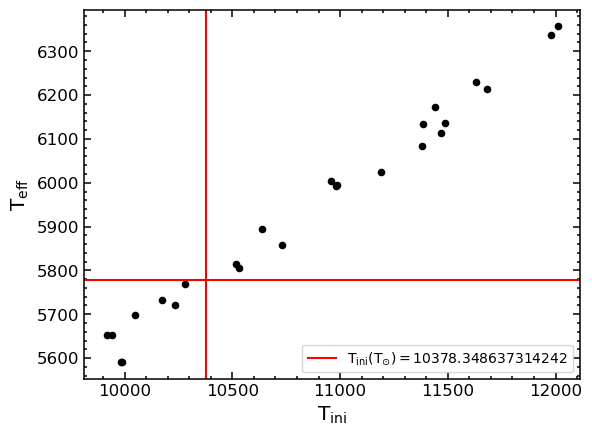

In [34]:
close("all")

f, ax  = plt.subplots(1,1, sharex=true)
basic_plot!(ax)

ax.scatter(t_ini, t_eff, color="k", s=20)
ax.set_xlabel(@L_str("\\rm T_{ini}"), fontsize="x-large")
ax.set_ylabel(@L_str("\\rm T_{eff}"), fontsize="x-large")

solar_teff=5777.0
ax.axhline(solar_teff, color="red")
ax.axvline(get_initial(t_ini, t_eff; goal=solar_teff), color="red", label=L"\rm T_{ini}(T_{\odot})="*"$(get_initial(t_ini, t_eff; goal=solar_teff))");
plt.legend()

gcf()

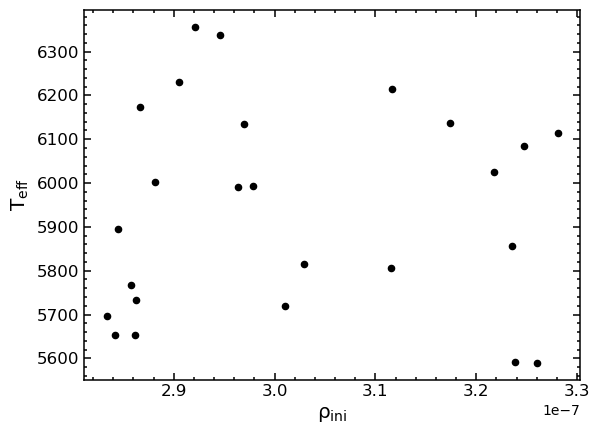

In [30]:
close("all")

f, ax  = plt.subplots(1,1, sharex=true)
basic_plot!(ax)

ax.scatter(d_ini, t_eff, color="k", s=20)
ax.set_xlabel(@L_str("\\rm \\rho_{ini}"), fontsize="x-large")
ax.set_ylabel(@L_str("\\rm T_{eff}"), fontsize="x-large");

gcf()

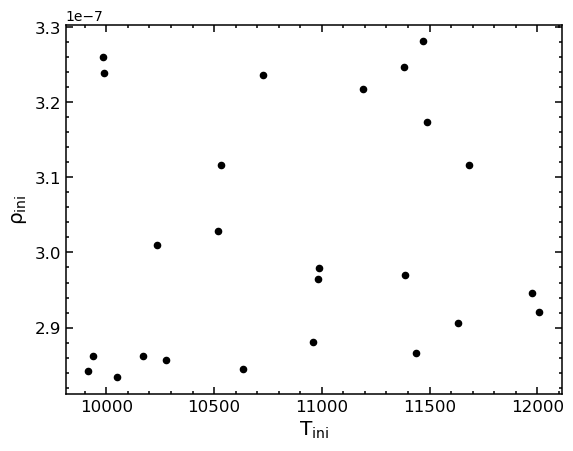

In [35]:
close("all")

f, ax  = plt.subplots(1,1, sharex=true)
basic_plot!(ax)

ax.scatter(t_ini, d_ini, color="k", s=20)
ax.set_xlabel(@L_str("\\rm T_{ini}"), fontsize="x-large")
ax.set_ylabel(@L_str("\\rm \\rho_{ini}"), fontsize="x-large");

gcf()

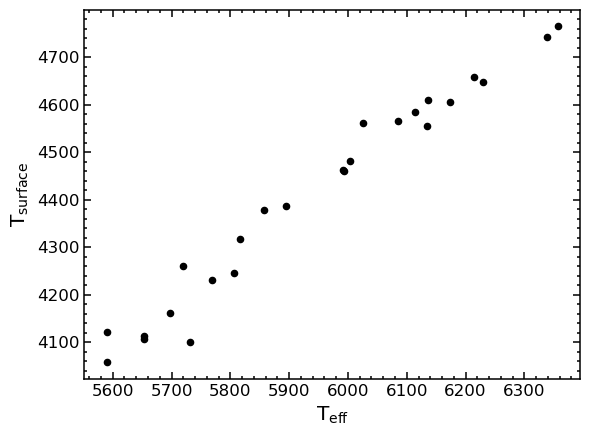

In [36]:
close("all")

f, ax  = plt.subplots(1,1, sharex=true)
basic_plot!(ax)

ax.scatter(t_eff, t_s, color="k", s=20)
ax.set_xlabel(@L_str("\\rm T_{eff}"), fontsize="x-large")
ax.set_ylabel(@L_str("\\rm T_{surface}"), fontsize="x-large");

gcf()